https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic  
https://medium.com/@asteinbach/actor-critic-using-deep-rl-continuous-mountain-car-in-tensorflow-4c1fb2110f7c

# Actor-Critic

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

import collections
import tqdm
import time
import matplotlib.pyplot as plt

## uncomment one of the following lines to use tensorflow or pytorch
from a2c_tf import *
# from a2c_torch import *

## Playing with discrete actions

In [2]:
env = gym.make("CartPole-v1")
a2c = A2CDiscrete(env=env,
                  n_actions=2,
                  reward_type="int32",
                  gamma=0.95)

## Playing with continuous actions

In [3]:
env = gym.make('MountainCarContinuous-v0')
a2c = A2CContinuous(env=env,
                    n_actions=1,
                    reward_type="float32",
                    gamma=0.95)

## Train the agent

In [4]:
%%time

min_episodes_criterion = 10
max_episodes = 500
max_steps_per_episode = 500

# consecutive trials
running_reward = 0
rewards = []

# Keep last episodes reward
episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)

with tqdm.trange(max_episodes) as t:
    for i in t:
        episode_reward = float(a2c.train_step(env.reset()[0], max_steps_per_episode))

        episodes_reward.append(episode_reward)
        running_reward = np.mean(episodes_reward)
        rewards.append(episode_reward)

        t.set_description(f'Episode {i}')
        t.set_postfix(episode_reward=episode_reward, running_reward=running_reward)

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

Episode 499: 100%|██████████| 500/500 [01:49<00:00,  4.56it/s, episode_reward=-50, running_reward=-38.9]  


Solved at episode 499: average reward: -38.92!
CPU times: user 3min 7s, sys: 9.62 s, total: 3min 17s
Wall time: 1min 49s


## Plot rewards

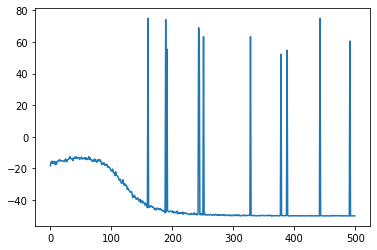

In [5]:
plt.plot(rewards);

## Use agent

In [6]:
# screen = a2c.env.render(mode='rgb_array')

state = a2c.env.reset()[0]
initial_state_shape = state.shape

for i in range(max_steps_per_episode):
    state = np.expand_dims(state, 0)
    
    if isinstance(a2c, A2CDiscrete):
        action_probs, _ = a2c.model(state)
        action = np.argmax(list(np.squeeze(action_probs)))
    elif isinstance(a2c, A2CContinuous):
        _, norm_dist, _ = a2c.model(state)
        action = norm_dist.loc
    
    state, _, done, _, _ = a2c.env.step(action)
    state = np.reshape(state, initial_state_shape)

    # screen = a2c.env.render(mode='rgb_array')
    # time.sleep(0.05)
    if done:
        break